In [15]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#dropping unnecessary columns
df = pd.read_csv('/content/drive/MyDrive/ai vasko tashkovski/dataset.csv')
df = df.drop(columns=["patient_id", "encounter_id", "icu_id", "weight"], axis=1)

In [16]:
df

hospital_id   age        bmi  elective_surgery  ethnicity gender  \
0              118  68.0  22.730000                 0  Caucasian      M   
1               81  77.0  27.420000                 0  Caucasian      F   
2              118  25.0  31.950000                 0  Caucasian      F   
3              118  81.0  22.640000                 1  Caucasian      F   
4               33  19.0        NaN                 0  Caucasian      M   
...            ...   ...        ...               ...        ...    ...   
91708           30  75.0  23.060250                 0  Caucasian      M   
91709          121  56.0  47.179671                 0  Caucasian      F   
91710          195  48.0  27.236914                 0  Caucasian      M   
91711           66   NaN  23.297481                 0  Caucasian      F   
91712          104  82.0  22.031250                 1  Caucasian      F   

       height           icu_admit_source icu_stay_type      icu_type  ...  \
0       180.3                      Floor         admit         CTICU  ...   
1       160.0                      Floor         admit  Med-Surg ICU  ...   
2       172.7       Accident & Emergency         admit  Med-Surg ICU  ...   
3       165.1  Operating Room / Recovery         admit         CTICU  ...   
4       188.0       Accident & Emergency         admit  Med-Surg ICU  ...   
...       ...                        ...           ...           ...  ...   
91708   177.8                      Floor         admit   Cardiac ICU  ...   
91709   183.0                      Floor         admit  Med-Surg ICU  ...   
91710   170.2       Accident & Emergency         admit  Med-Surg ICU  ...   
91711   154.9       Accident & Emergency         admit  Med-Surg ICU  ...   
91712   160.0  Operating Room / Recovery         admit  Med-Surg ICU  ...   

       diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  \
0                    1.0              0.0                0.0       0.0   
1                    1.0              0.0                0.0       0.0   
2                    0.0              0.0                0.0       0.0   
3                    0.0              0.0                0.0       0.0   
4                    0.0              0.0                0.0       0.0   
...                  ...              ...                ...       ...   
91708                1.0              0.0                0.0       0.0   
91709                0.0              0.0                0.0       0.0   
91710                1.0              0.0                0.0       0.0   
91711                0.0              0.0                0.0       0.0   
91712                0.0              0.0                0.0       0.0   

       lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  \
0           0.0                          0.0                Sepsis   
1           0.0                          0.0           Respiratory   
2           0.0                          0.0             Metabolic   
3           0.0                          0.0        Cardiovascular   
4           0.0                          0.0                Trauma   
...         ...                          ...                   ...   
91708       0.0                          1.0                Sepsis   
91709       0.0                          0.0                Sepsis   
91710       0.0                          0.0             Metabolic   
91711       0.0                          0.0           Respiratory   
91712       0.0                          0.0      Gastrointestinal   

       apache_2_bodysystem  Unnamed: 83  hospital_death  
0           Cardiovascular          NaN               0  
1              Respiratory          NaN               0  
2                Metabolic          NaN               0  
3           Cardiovascular          NaN               0  
4                   Trauma          NaN               0  
...                    ...          ...             ...  
91708       Cardiovascular          NaN      

How many NA values there are for each feature

In [17]:
null_counts = df.isnull().sum()

Dropping off rows with NaN values for values which we cannot reliably predict and are too important to mess up

In [18]:
list_toRemove = ['bmi', 'gender', 'age', "gcs_unable_apache", "leukemia", "lymphoma", "solid_tumor_with_metastasis", "apache_3j_bodysystem", "apache_2_bodysystem", "ventilated_apache"]

for feature in list_toRemove:
    df = df[df[feature].notna()]

# Visualisations

Deaths by gender

In [19]:

import plotly.express as px
fig = px.histogram(df[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender",
                   marginal="box", # or violin, rug
                   hover_data=df[['age','gender','hospital_death','bmi']].columns)
fig.show()

Deaths by the type of intensive care unit

In [20]:
ICU_type=df[['icu_type','age','hospital_death']]
ICU_type['icu_type']=ICU_type['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})
ICU_df=ICU_type.groupby(['icu_type','age']).mean().reset_index()
ICU_df['count']=ICU_type.groupby(['icu_type','age']).count().reset_index()['hospital_death']

fig = px.line(ICU_df, x="age", y="hospital_death", color="icu_type",
           hover_name="icu_type", log_x=False)
fig.update_layout(
    title_text="<b>Survival rate at different types of ICU<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(title_text="<b>Age<b>")
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Death rate rank list for hospitals

In [21]:
newdf = pd.read_csv('/content/drive/MyDrive/ai vasko tashkovski/newdf.csv')
hos=df['hospital_id'].unique().tolist()
hos.sort()
deaths=newdf['0']
deaths.tolist()
freq=[]
for i in range(1,len(deaths),2):
  freq.append(deaths[i-1]/(deaths[i]+deaths[i-1]))
hosfreq=dict(zip(hos,freq))
hosfreq = sorted(hosfreq.items(), key=lambda x:x[1])
hosfreq=dict(hosfreq)
neww= pd.DataFrame.from_dict(hosfreq, orient="index").reset_index()
neww.columns = ['Hostpital_ID', 'Death_rate']
neww=neww[(neww != 0).all(1)]
print(neww)

     Hostpital_ID  Death_rate
6              74    0.000905
7             142    0.002469
8              78    0.002876
9             117    0.002971
10            130    0.002985
..            ...         ...
141           118    0.520408
142           196    0.662791
143           128    0.783133
144           166    0.795455
145           176    0.828916

[140 rows x 2 columns]


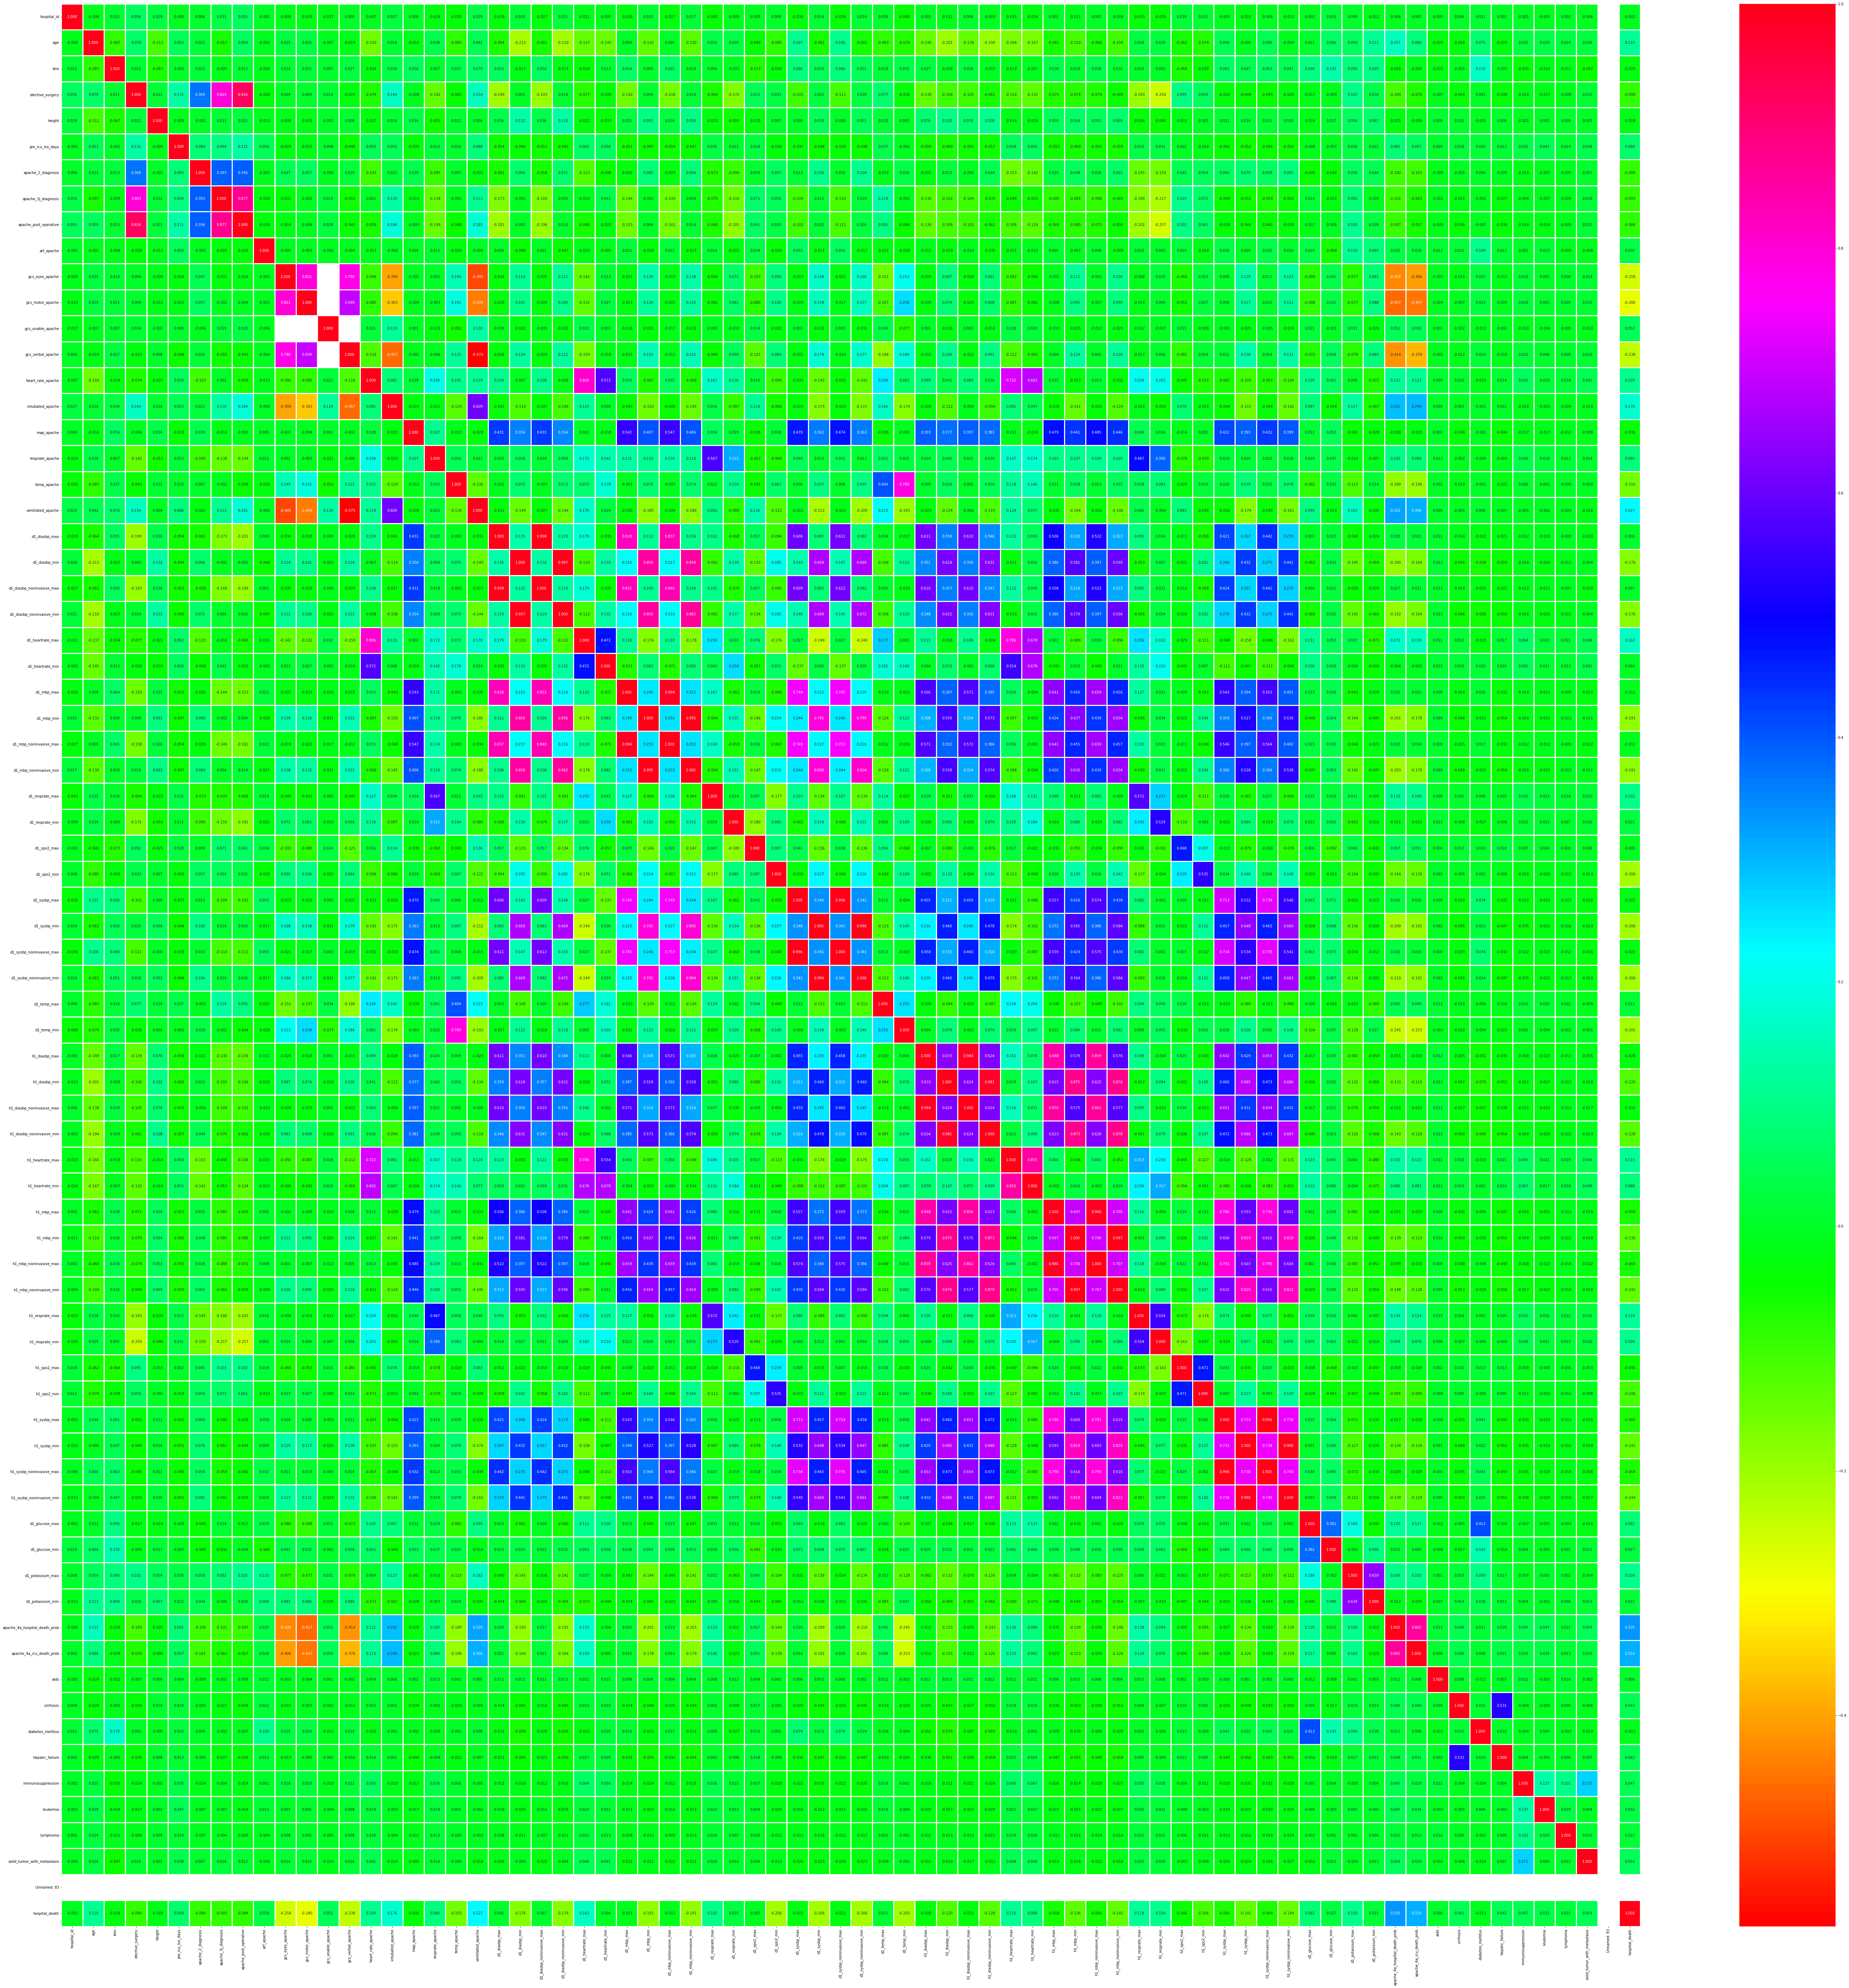

In [23]:
#Heatmap of correlation
plt.figure(figsize=(100,100))
sns.heatmap(df.corr(),annot=True, cmap='hsv', fmt='.3f', linewidths=2)

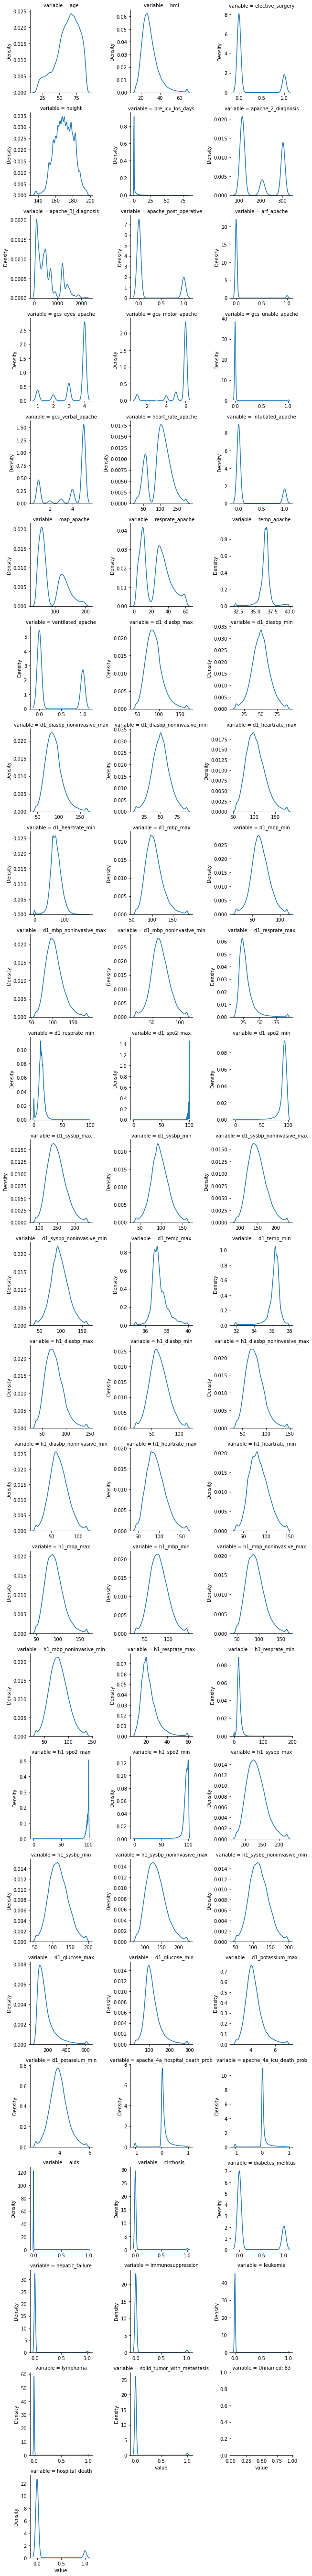

In [24]:
unpivot = pd.melt(df, df.describe().columns[0], df.describe().columns[1:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

In [25]:
# Encoding the strings

df = df.apply(LabelEncoder().fit_transform)

list = []
for col in df.columns:
    list.append(col)
    #print(col)
remove = ["hospital_death"]
for elem in remove:
    list.remove(elem)


df1 = df
scaler = MinMaxScaler()

for feature in list:
    df[feature] = scaler.fit_transform(df[feature].to_numpy().reshape(-1, 1))
    knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
    df[feature] = knn_imputer.fit_transform(df[[feature]])

df_knn_imputer = df

# Data preperation

In [26]:
from sklearn.preprocessing import LabelEncoder

df = df.apply(LabelEncoder().fit_transform) 

In [27]:
list = []
for col in df.columns:
    list.append(col)
    #print(col)
remove = ["hospital_id", "hospital_death"]
for elem in remove:
    list.remove(elem)

Filling up the NaN values with K nearest neighbours

In [28]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
df1 = df
scaler = MinMaxScaler()
list.append("hospital_id")
for feature in list:
    df[feature] = scaler.fit_transform(df[feature].to_numpy().reshape(-1, 1))
    knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
    df[feature] = knn_imputer.fit_transform(df[[feature]])

df_knn_imputer = df

Splitting the data

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df[df.columns[:-1]], df['hospital_death'], test_size = 0.25, random_state=0)

# Models

Trying out with different neural network shapes

Model 1

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
temp = Sequential()
temp.add(Dense(81,input_dim=80,  activation='relu'))
temp.add(Dropout(0.2, input_dim=(81,)))
temp.add(Dense(27, activation='relu'))
temp.add(Dropout(0.2, input_dim=(27,)))
temp.add(Dense(9, activation='relu'))
temp.add(Dropout(0.2, input_dim=(9,)))
temp.add(Dense(3,activation='relu'))
temp.add(Dense(1, activation='sigmoid'))
temp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
temp.fit(X_train,Y_train,epochs=20, batch_size=64)
y_pred = temp.predict(X_test)

Epoch 1/20
976/976 [==============================] - 3s 2ms/step - loss: 0.3051 - accuracy: 0.9059
Epoch 2/20
976/976 [==============================] - 2s 2ms/step - loss: 0.2285 - accuracy: 0.9213
Epoch 3/20
976/976 [==============================] - 2s 2ms/step - loss: 0.2188 - accuracy: 0.9231
Epoch 4/20
976/976 [==============================] - 2s 2ms/step - loss: 0.2127 - accuracy: 0.9236
Epoch 5/20
976/976 [==============================] - 2s 2ms/step - loss: 0.2094 - accuracy: 0.9243
Epoch 6/20
976/976 [==============================] - 3s 3ms/step - loss: 0.2073 - accuracy: 0.9241
Epoch 7/20
976/976 [==============================] - 2s 2ms/step - loss: 0.2060 - accuracy: 0.9250
Epoch 8/20
976/976 [==============================] - 3s 3ms/step - loss: 0.2052 - accuracy: 0.9253
Epoch 9/20
976/976 [==============================] - 4s 4ms/step - loss: 0.2034 - accuracy: 0.9258
Epoch 10/20
976/976 [==============================] - 4s 4ms/step - loss: 0.2024 - accuracy: 0.9262

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_pred.round())

0.9310908217203268

Model 2

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Flatten, Dropout
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

n_features = len(X_train.columns)
input_shape=(n_features, 1)

model = Sequential()

model.add(Dense(53, input_dim=n_features, kernel_initializer='uniform', activation='relu'))
model.add(Dense(36, kernel_initializer='uniform', activation='relu'))
model.add(Dense(24, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(36, kernel_initializer='uniform', activation='relu'))
model.add(Dense(53, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(36, kernel_initializer='uniform', activation='relu'))
model.add(Dense(24, kernel_initializer='uniform', activation='relu'))
model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=25, batch_size=50)

Epoch 1/25
1249/1249 [==============================] - 4s 3ms/step - loss: 0.2479 - accuracy: 0.9162
Epoch 2/25
1249/1249 [==============================] - 3s 3ms/step - loss: 0.2162 - accuracy: 0.9162
Epoch 3/25
1249/1249 [==============================] - 3s 3ms/step - loss: 0.2111 - accuracy: 0.9169
Epoch 4/25
1249/1249 [==============================] - 3s 2ms/step - loss: 0.2096 - accuracy: 0.9237
Epoch 5/25
1249/1249 [==============================] - 3s 2ms/step - loss: 0.2080 - accuracy: 0.9244
Epoch 6/25
1249/1249 [==============================] - 3s 3ms/step - loss: 0.2060 - accuracy: 0.9250
Epoch 7/25
1249/1249 [==============================] - 3s 3ms/step - loss: 0.2050 - accuracy: 0.9252
Epoch 8/25
1249/1249 [==============================] - 3s 3ms/step - loss: 0.2041 - accuracy: 0.9256
Epoch 9/25
1249/1249 [==============================] - 3s 3ms/step - loss: 0.2030 - accuracy: 0.9262
Epoch 10/25
1249/1249 [==============================] - 3s 3ms/step - loss: 0.202

In [35]:
_, accuracy = model.evaluate(X_train, Y_train)
print('Accuracy: %.2f' % (accuracy*100))

1951/1951 [==============================] - 3s 1ms/step - loss: 0.1919 - accuracy: 0.9300
Accuracy: 93.00


XGBoost

In [36]:
from xgboost import XGBClassifier

#inicialize XGBoost
model = XGBClassifier(max_depth=100, min_child_weight=1,  n_estimators=150, n_jobs=-1, verbose=1, learning_rate=0.15)
model.fit(X_train, Y_train)

XGBClassifier(learning_rate=0.15, max_depth=100, n_estimators=150, n_jobs=-1,
              verbose=1)

In [37]:
y_pred = model.predict(X_test)

from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.9335896203748199


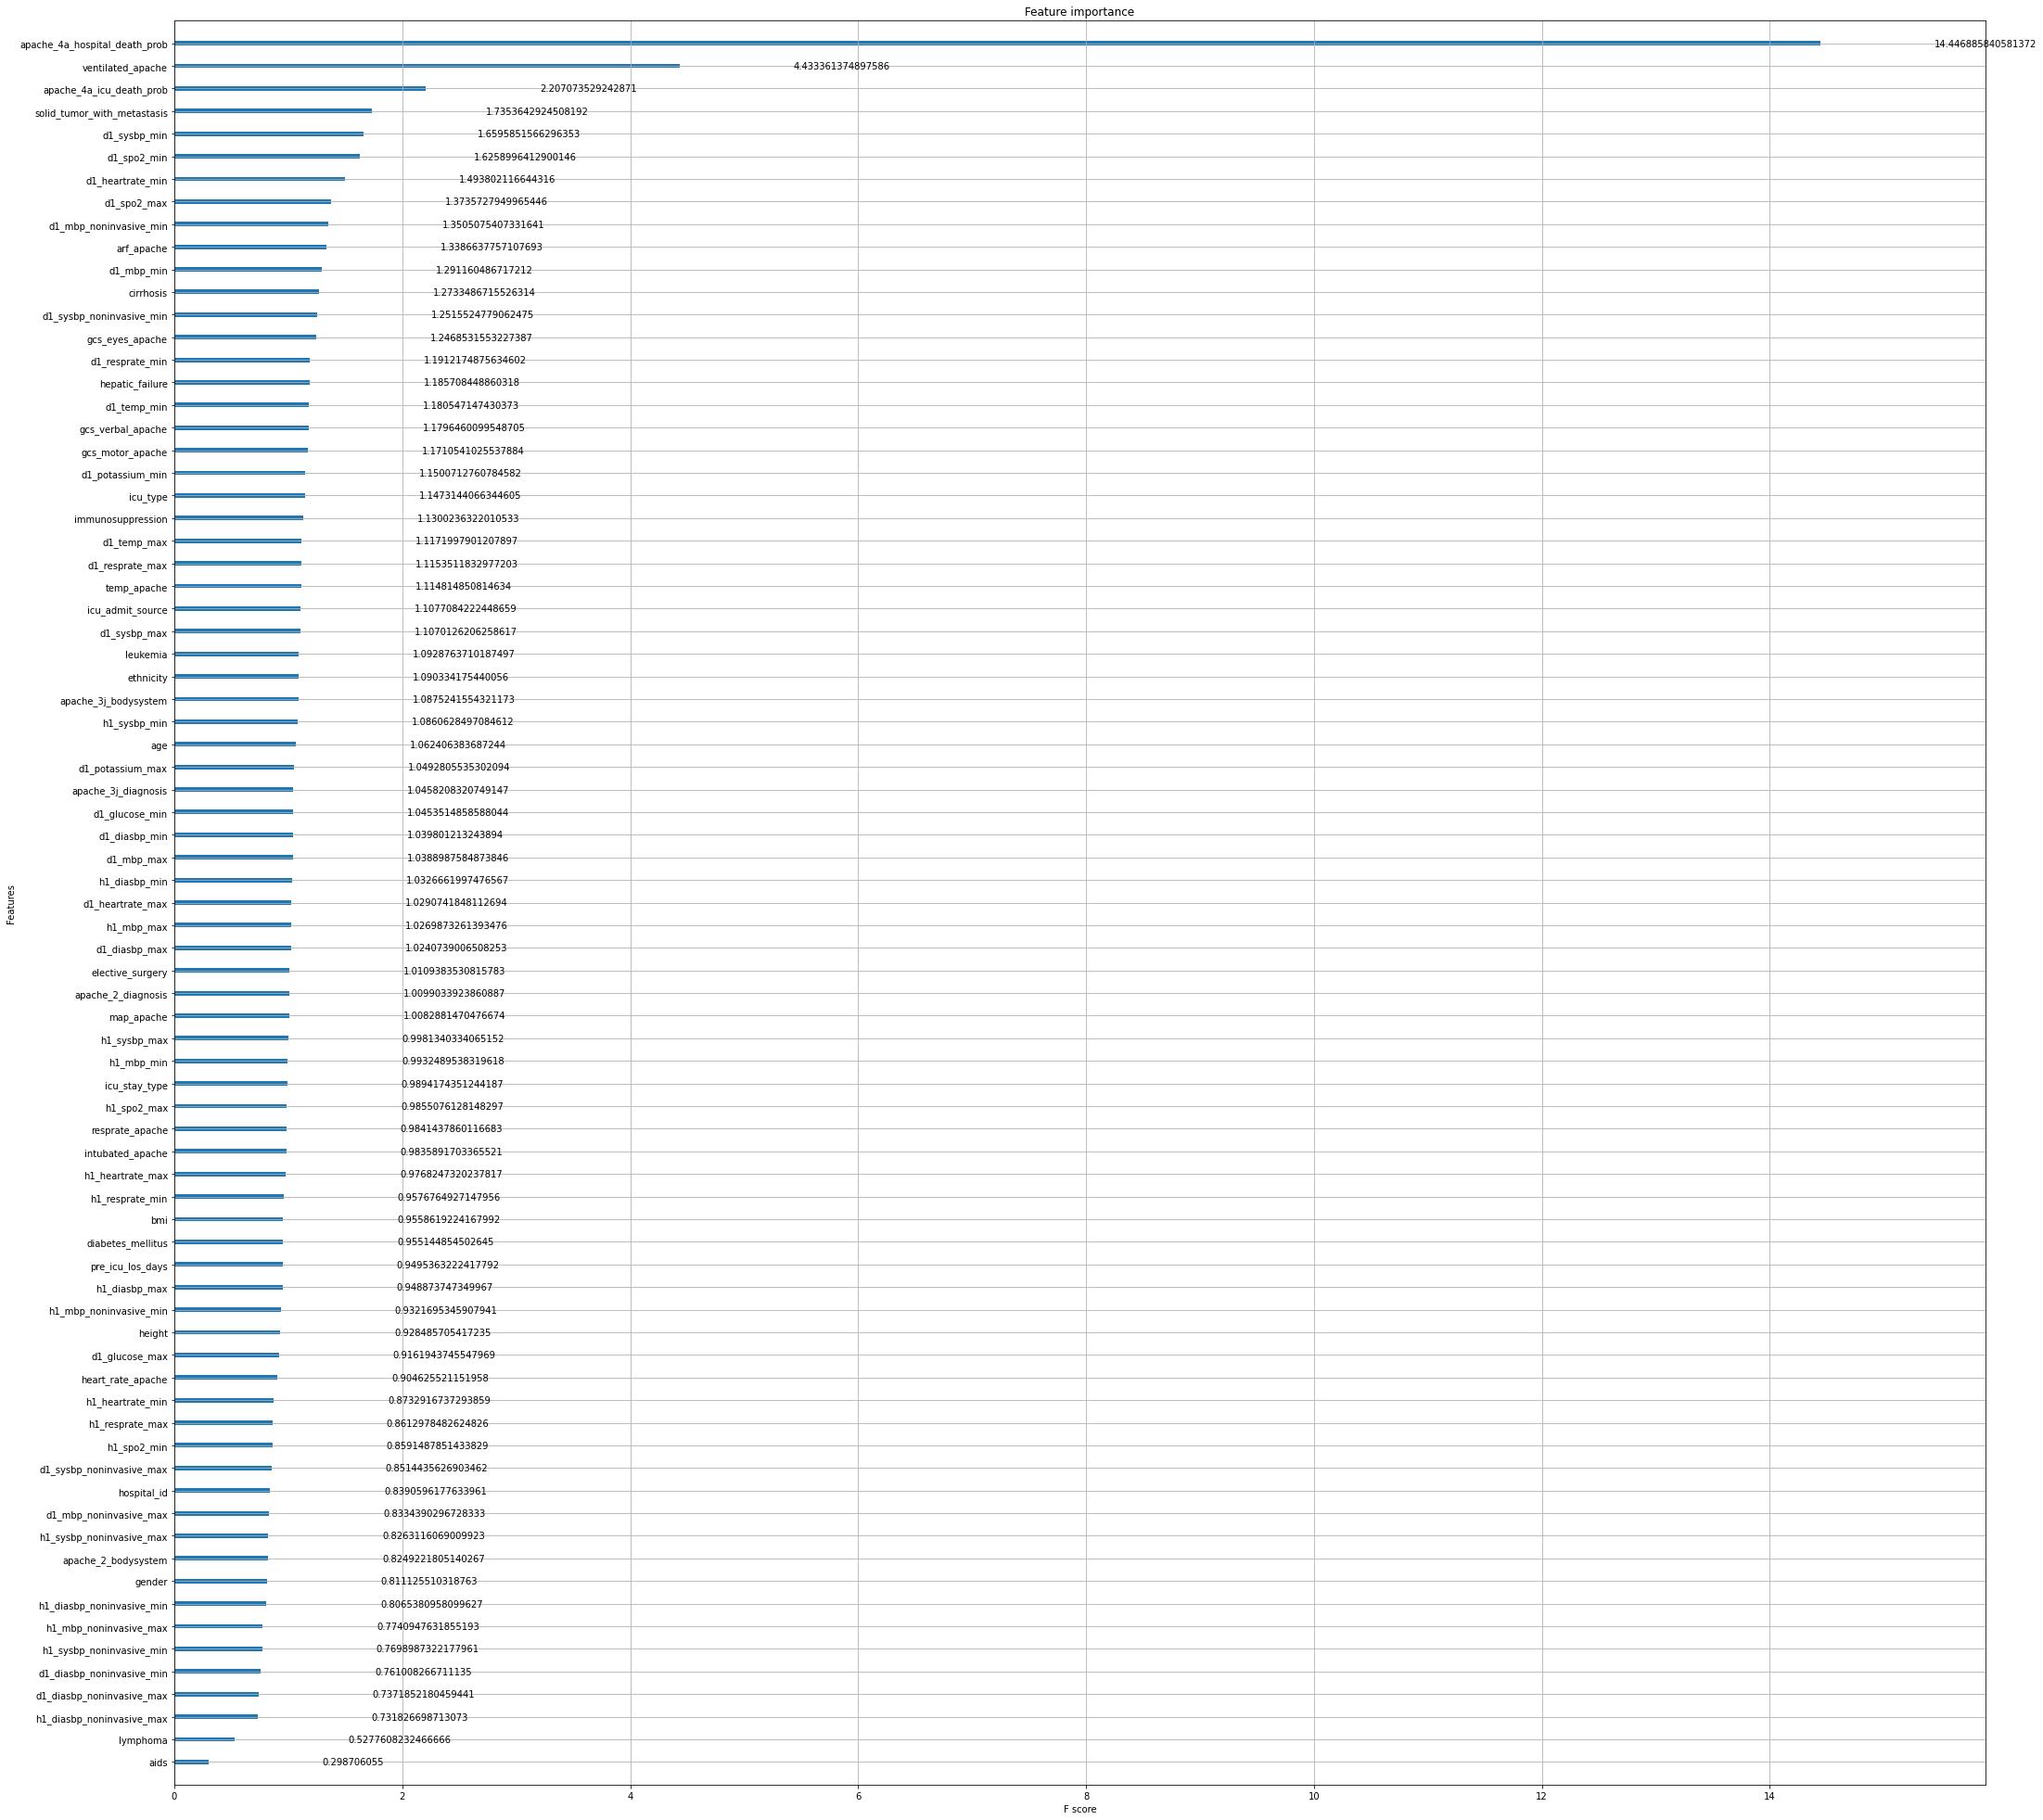

In [39]:
from xgboost import plot_importance

plot_importance(model, importance_type='gain')
plt.rcParams['figure.figsize'] = [35, 35]
plt.show()